## Q2. K-means
1. Implement k-means clustering algorithm from scratch.
2. Choose k = 3, 5, 7. Use only numerical attributes to cluster.
3. Use elbow method and Silhouette Score to get optimal number of clusters.
4. Analyse the results got in every case and try to mark each cluster.

## Imports

In [3]:
import sys
import numpy as np
import matplotlib.pyplot
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import silhouette_samples
np.set_printoptions(threshold=sys.maxsize)

## Preprocessing the data before clustering

While preprocessing the data, we have converted all objects values to numerical float values so they can be used for kmeans, imputed all missing values by the mean of the same attribute, and standardized the entries attribute wise to prevent large vectors from dominating.  

In [4]:
dataset = pd.read_csv('../football_data.csv')

In [5]:
'''
Listing the attributes, loading the data and the headers
'''
toKeep = np.array([3, 7, 8, 11, 12, 13, 15, 16, 17, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88])
X = dataset.iloc[:,toKeep].values
header = dataset.iloc[:,toKeep].columns

print("Getting the data and headers.")
print("Shape of new data:", X.shape)

row_length = X.shape[0]
col_length = X.shape[1]
# print(row_length)
# print(col_length)

overview_value_wage_arr = [3,4,X.shape[1]-1]
overview_value_wage_arr = np.array(overview_value_wage_arr)

'''
Removing Euro, Million, and K sign from wage and values
'''
print("Removing Euro, Million, and K sign from wage and values.")
for j in overview_value_wage_arr:
    for i in range(row_length):
        if type(X[i,j]) is not float:
            last_char = X[i,j][-1]
            if last_char == 'M':
                X[i,j] = 1000000*float(X[i,j][1:-1])
            elif last_char == 'K':
                X[i,j] = 1000*float(X[i,j][1:-1])
            else:
                X[i,j]=0

'''
Extracting year from date
'''
print("Extracting year from date.")
for j in range(10,12):
    for i in range(row_length):
        if type(X[i,j]) is not float:
            year = X[i,j][-4:]
            year = float(year)
            X[i,j] = year

'''
Getting height in inches
'''
print("Getting height in inches.")
for i in range (row_length):
    if type(X[i,12]) is not float:
        hh = X[i,12].split("'")
        ft = float(hh[0])
        ich = float(hh[1])
        ich = ich + 12*ft
        float(ich)
        X[i,12]=ich
      
'''
Extracting weight value by removing "lbs"
'''
print("Extracting weight value by removing lbs.")
for i in range(X.shape[0]):
    if type(X[i,13]) is not float:
        wgt = X[i,13][:-3]
        wgt = float(wgt)
        X[i,13] = wgt
        
'''
Converting all numeric data to float
'''
print("Converting all numeric data to float.")
for i in range(40,col_length-1):
    X[:,i].astype(float)

'''
Removing "+" signs if any
'''
print("Removing + signs if any.")
for j in range(14,40):
    for i in range (row_length):
        if type(X[i,j]) is not float:
            hh = X[i,j].split("+")
            fv = float(hh[0])
            sv = float(hh[1])
            X[i,j]=fv+sv

X=X.astype(float)

'''
Replacing missing values (if any) by mean for each column
'''
print("Replacing missing values (if any) by mean for each column.")
import sklearn.impute
impobj = sklearn.impute.SimpleImputer(missing_values = np.nan, strategy = 'mean') 
for j in range(col_length):
    imppbj = impobj.fit(X[:, j:j+1])
    X[:, j:j+1] = impobj.transform(X[:, j:j+1])

'''
Standardize features by removing the mean and scaling to unit variance
'''
print("Standardize features by removing the mean and scaling to unit variance.")
import sklearn.preprocessing
X_std = sklearn.preprocessing.StandardScaler().fit_transform(X)

'''
Verifying that mean=0 and variance=1 for each attribute 
'''
print("Tabulating mean and variance to verify that mean=0 and variance=1 for each attribute:")
from prettytable import PrettyTable
t_tab = PrettyTable(['Column Number', 'Mean', 'Variance'])
for i in range(col_length):
    cc = X_std[:,i]
    t_tab.add_row([i+1, np.average(np.array(cc)).round(5), np.var(np.array(cc)).round(5)])
kkkkkk = X_std
print(t_tab)

Getting the data and headers.
Shape of new data: (18207, 75)
Removing Euro, Million, and K sign from wage and values.
Extracting year from date.
Getting height in inches.
Extracting weight value by removing lbs.
Converting all numeric data to float.
Removing + signs if any.
Replacing missing values (if any) by mean for each column.
Standardize features by removing the mean and scaling to unit variance.
Tabulating mean and variance to verify that mean=0 and variance=1 for each attribute:
+---------------+------+----------+
| Column Number | Mean | Variance |
+---------------+------+----------+
|       1       | 0.0  |   1.0    |
|       2       | 0.0  |   1.0    |
|       3       | 0.0  |   1.0    |
|       4       | -0.0 |   1.0    |
|       5       | 0.0  |   1.0    |
|       6       | -0.0 |   1.0    |
|       7       | -0.0 |   1.0    |
|       8       | -0.0 |   1.0    |
|       9       | -0.0 |   1.0    |
|       10      | -0.0 |   1.0    |
|       11      | -0.0 |   1.0    |
|   

## Class for K-Means Algorithm
This class implements the K-Means algorithm. Initially it randomly chooses |n_clusters| and starts forming clusters based on distances obtained using 75 attributes. The algorithm runs until no data point changes cluster or the maximum number of iterations have been run.

In [6]:
class Kmeans:

    def __init__(self, n_clusters, max_iter=100, random_state=np.random.randint(0, 1000, size=1)):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def comp_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):            
            '''
            calculating mean to get new  centroids
            '''
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids
    
    def comp_distance(self, X, centroids):
        '''
        initializing distance matrix
        '''
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            '''
            calculating distance for each point from k 
            '''
            arr = X - centroids[k,:]
            row_norm = norm(arr, axis=1)
            distance[:, k] = np.square(row_norm)
        return distance
    
    def fit(self, X):
        np.random.RandomState(self.random_state)
        '''
        randomising all examples in the dataset
        '''
        random_idx = np.random.permutation(X.shape[0])
        '''
        choosing n_clusters points as random centroids initially 
        '''
        self.centroids = X[random_idx[:self.n_clusters]]
           
        '''
        KMEANS ITERATIONS 
        '''
        for i in range(self.max_iter):
            o_centroids = self.centroids
            '''
            calculating the distance of every datapoint from each centroid 
            and finding closest centroid for all points
            '''
            distance = self.comp_distance(X, o_centroids)
            self.labels = np.argmin(distance, axis=1)
            self.centroids = self.comp_centroids(X, self.labels)
            '''
            If all centroids remain same then Kmeans is over
            '''
            if np.all(o_centroids == self.centroids):
                break
        '''
        calculating SSE (sum of squared error) for centroids
        '''
        dd = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            '''
            Finding distance of each point from mean to find data distribution
            '''
            dd[self.labels == k] = norm(X[self.labels == k] - self.centroids[k], axis=1)
        self.error = np.sum(np.square(dd))

    def predict(self, X):
        distance = self.comp_distance(X, self.centroids)
        return np.argmin(distance, axis=1)

## Running K-Means and plotting the graphs
Now we have run K-Means with values of K as 3, 5, and 7 respectively. For each K, K-means has been run multiple times with different initial centroids to make sure that the algorithm does not get trapped in some bias present in the data. It can be seen in the plots that result turn out to be roughly similar.  
  
K-means has used **75 attributes** to form the clusters. For visualization purpose, we have used 4 pairs of attributes and represented them on a 2D plane, with each cluster marked with a different colour. The pairs used are:
* Overall vs Gkdiving 
* Overall vs ST 
* Overall vs CM  
* Overall vs CB  

In [7]:
clist = ['#4DFF6A','#3355FF','#FF7733','#FF66E5','#FFFF00','#A9A9A9','#7e52c3']
llist = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7']

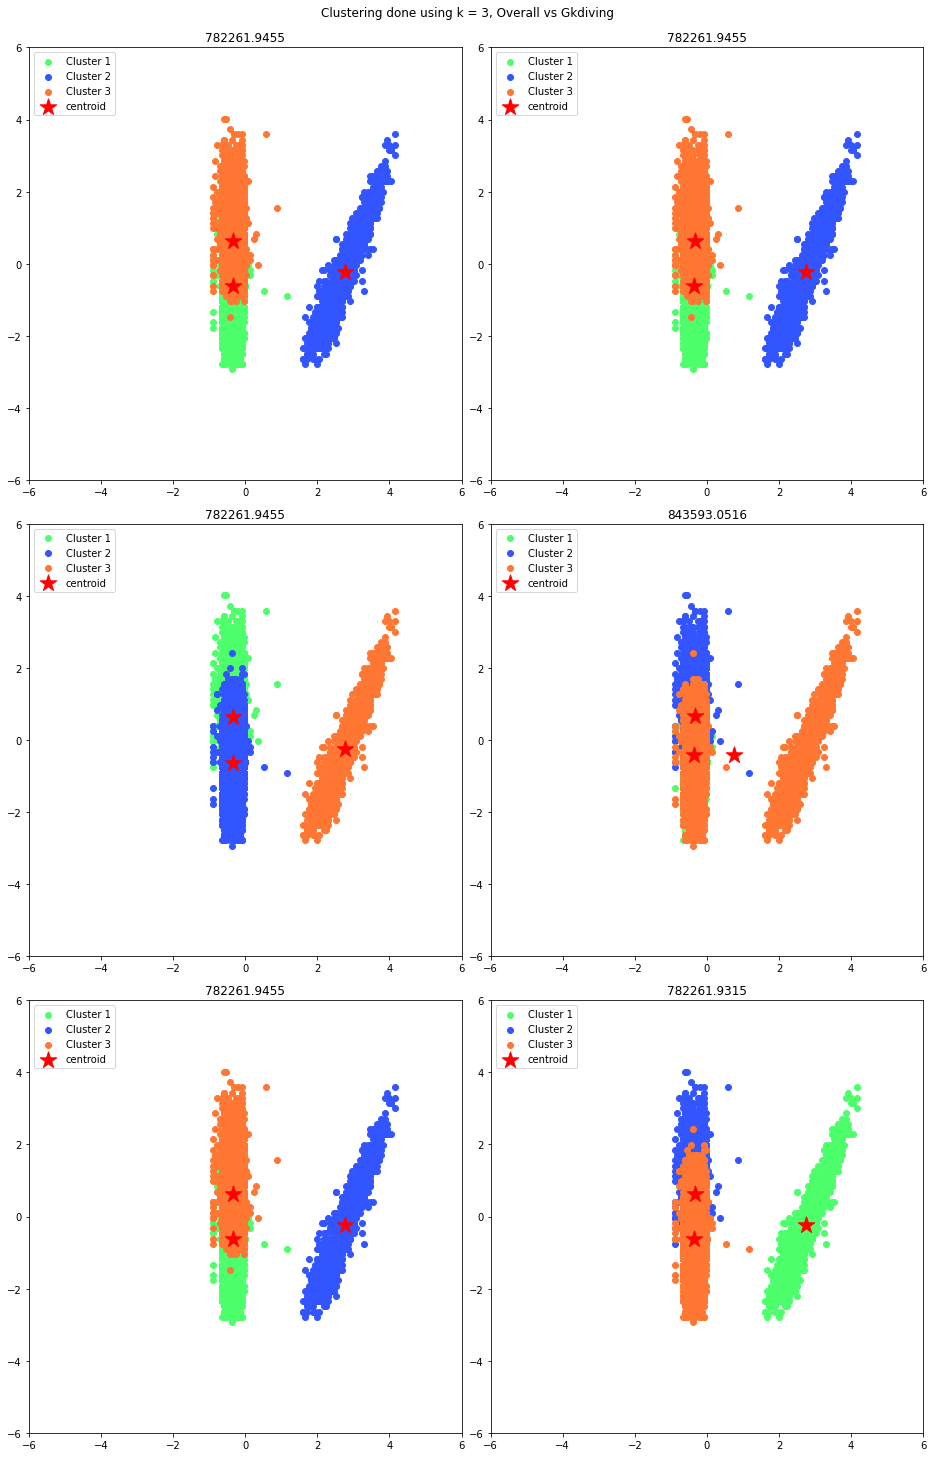

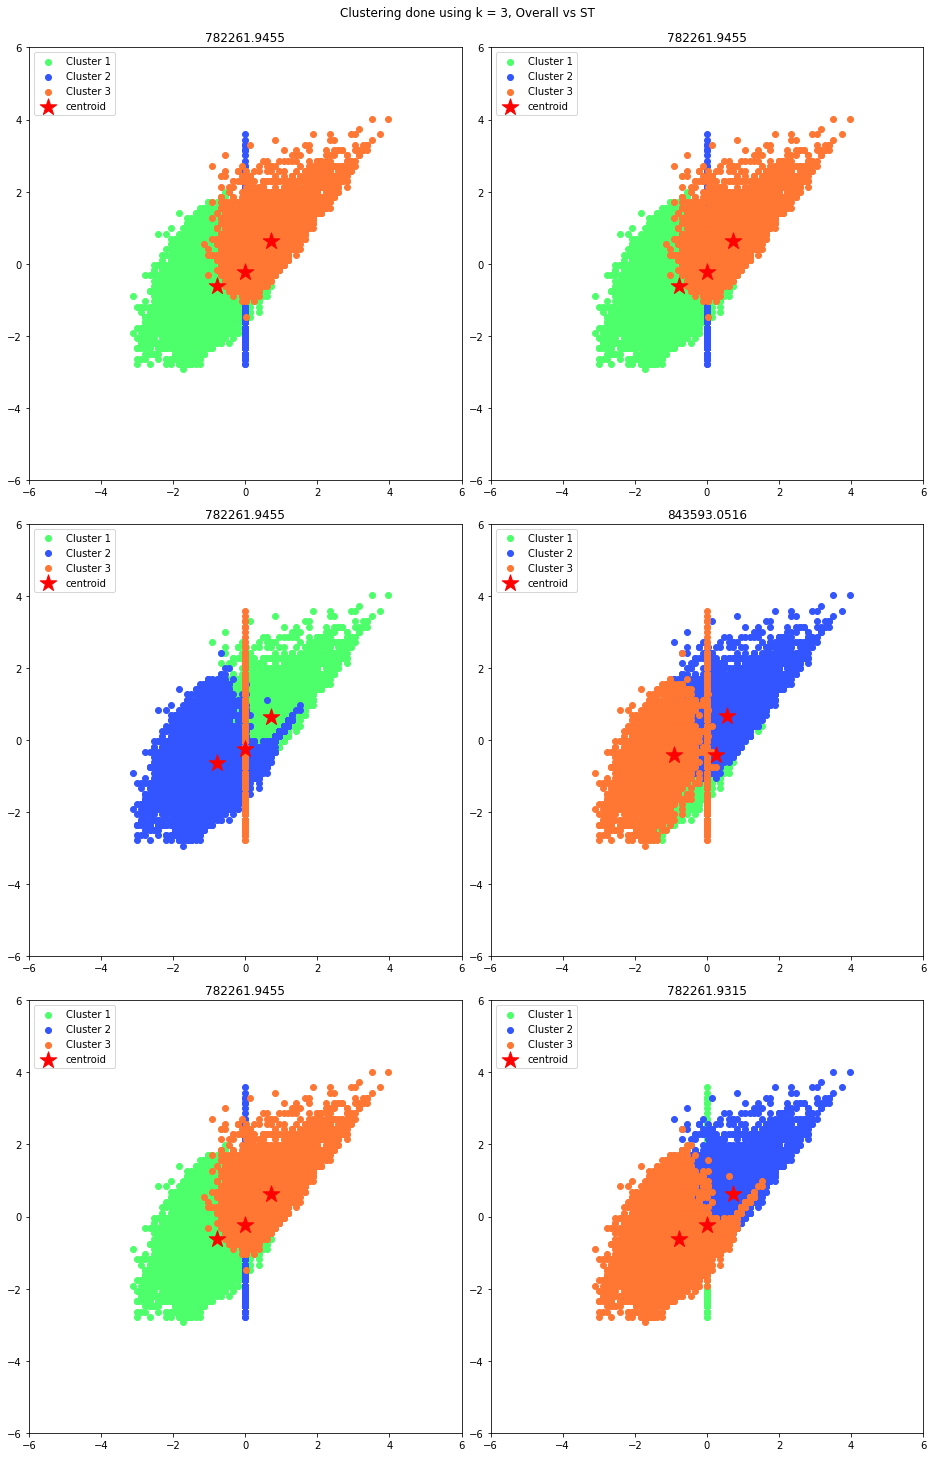

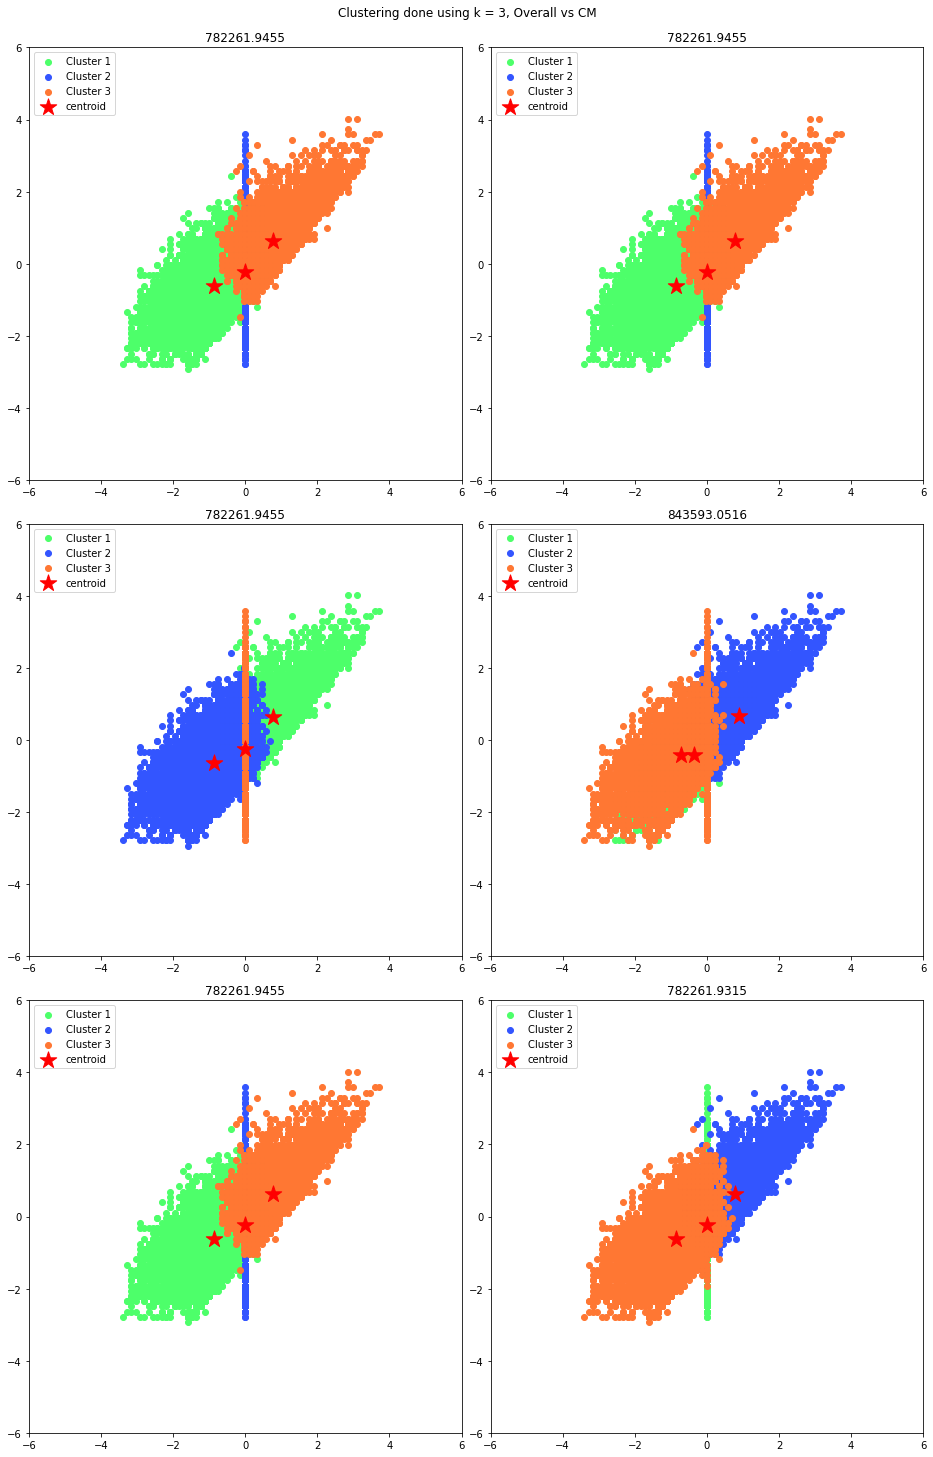

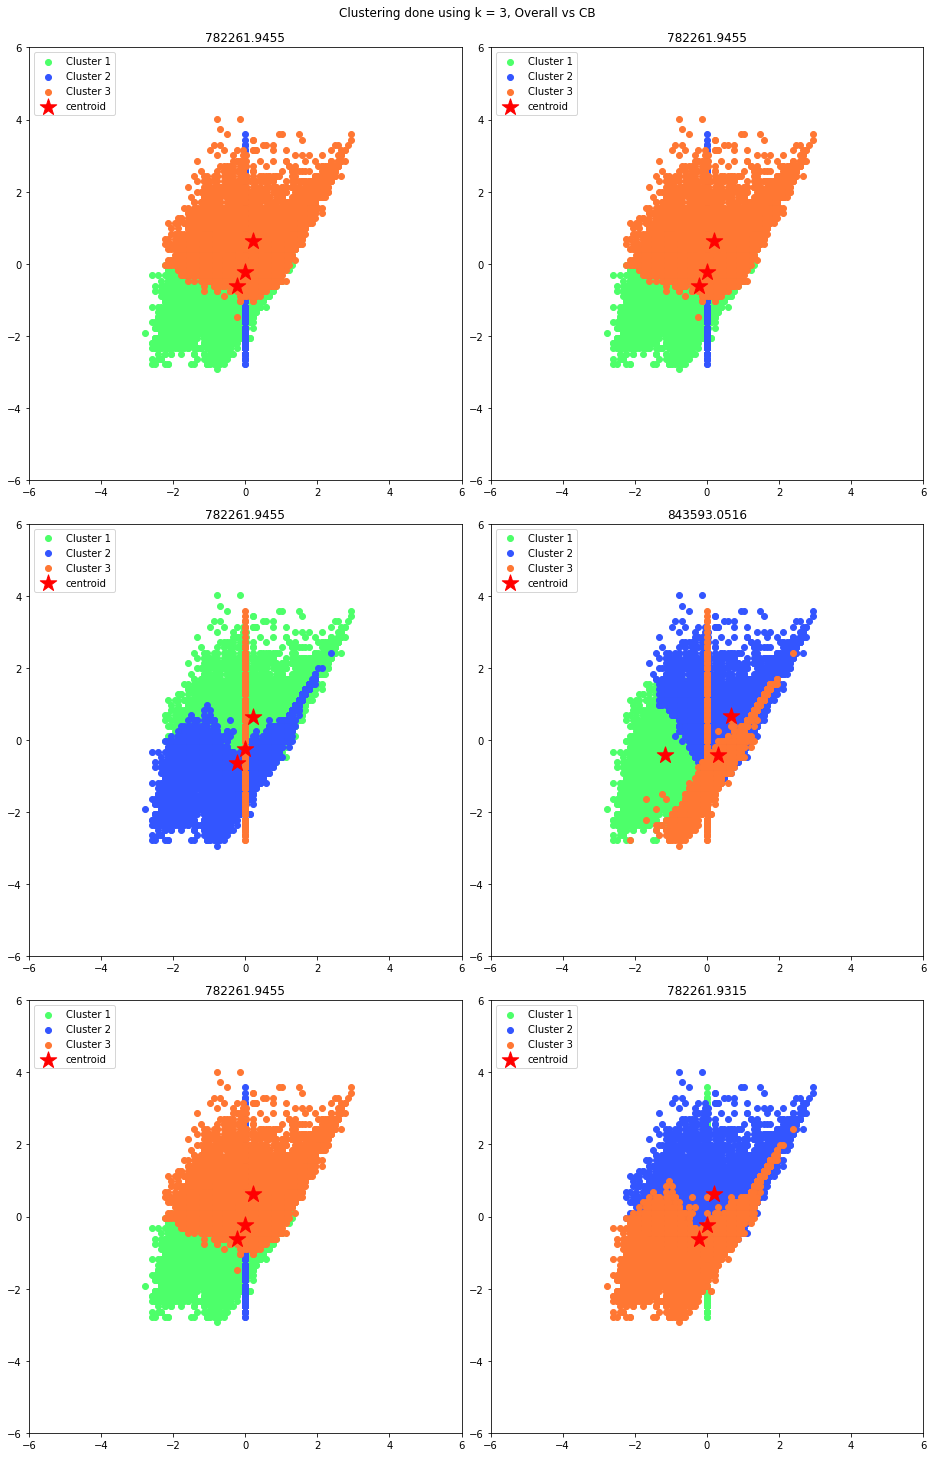

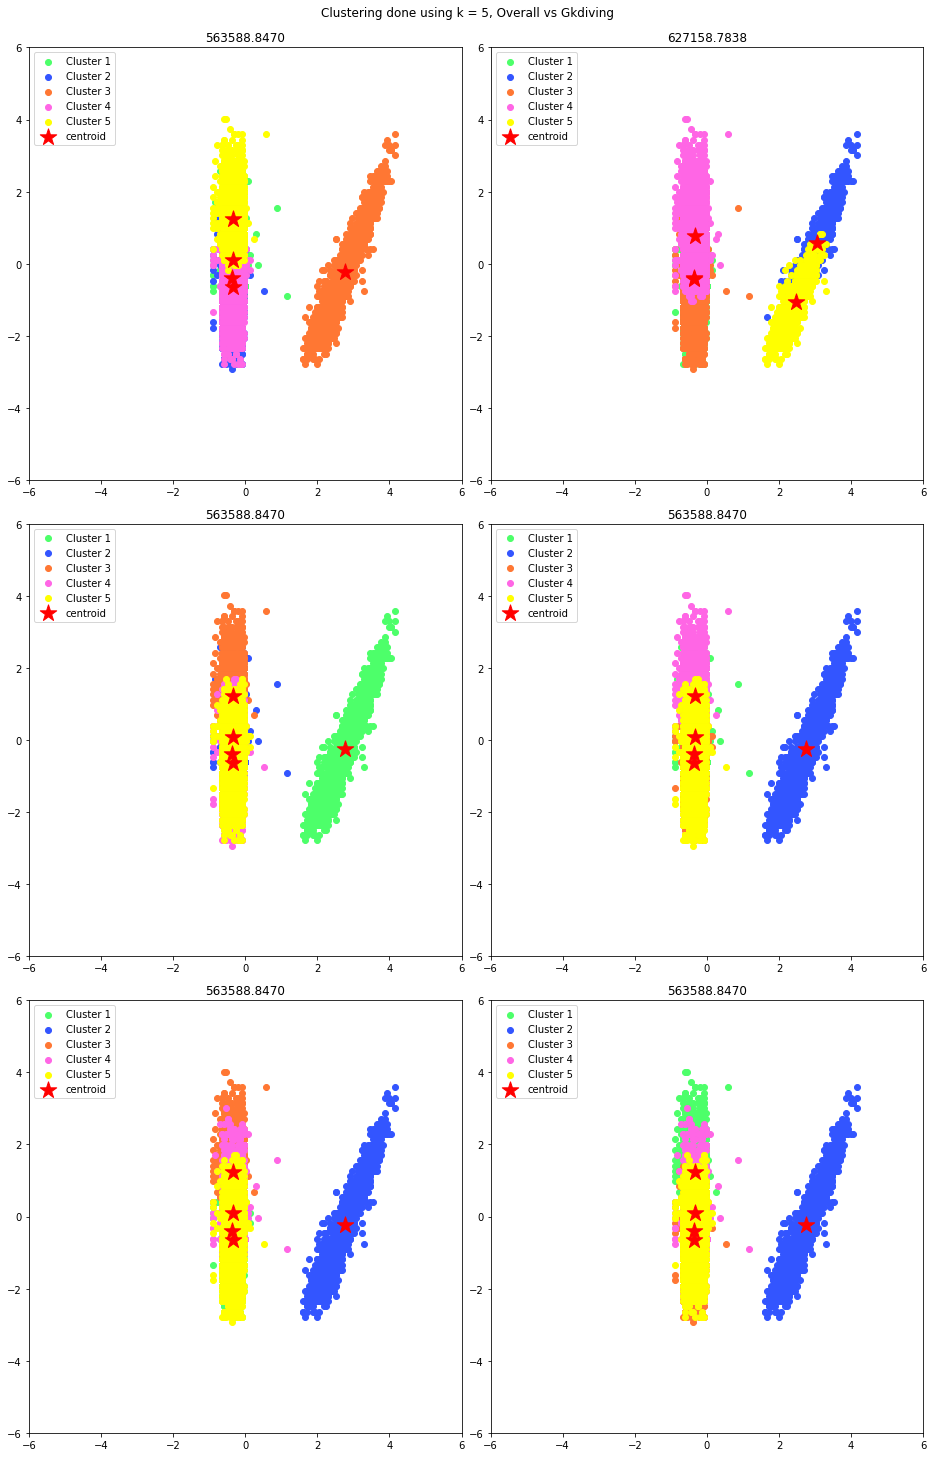

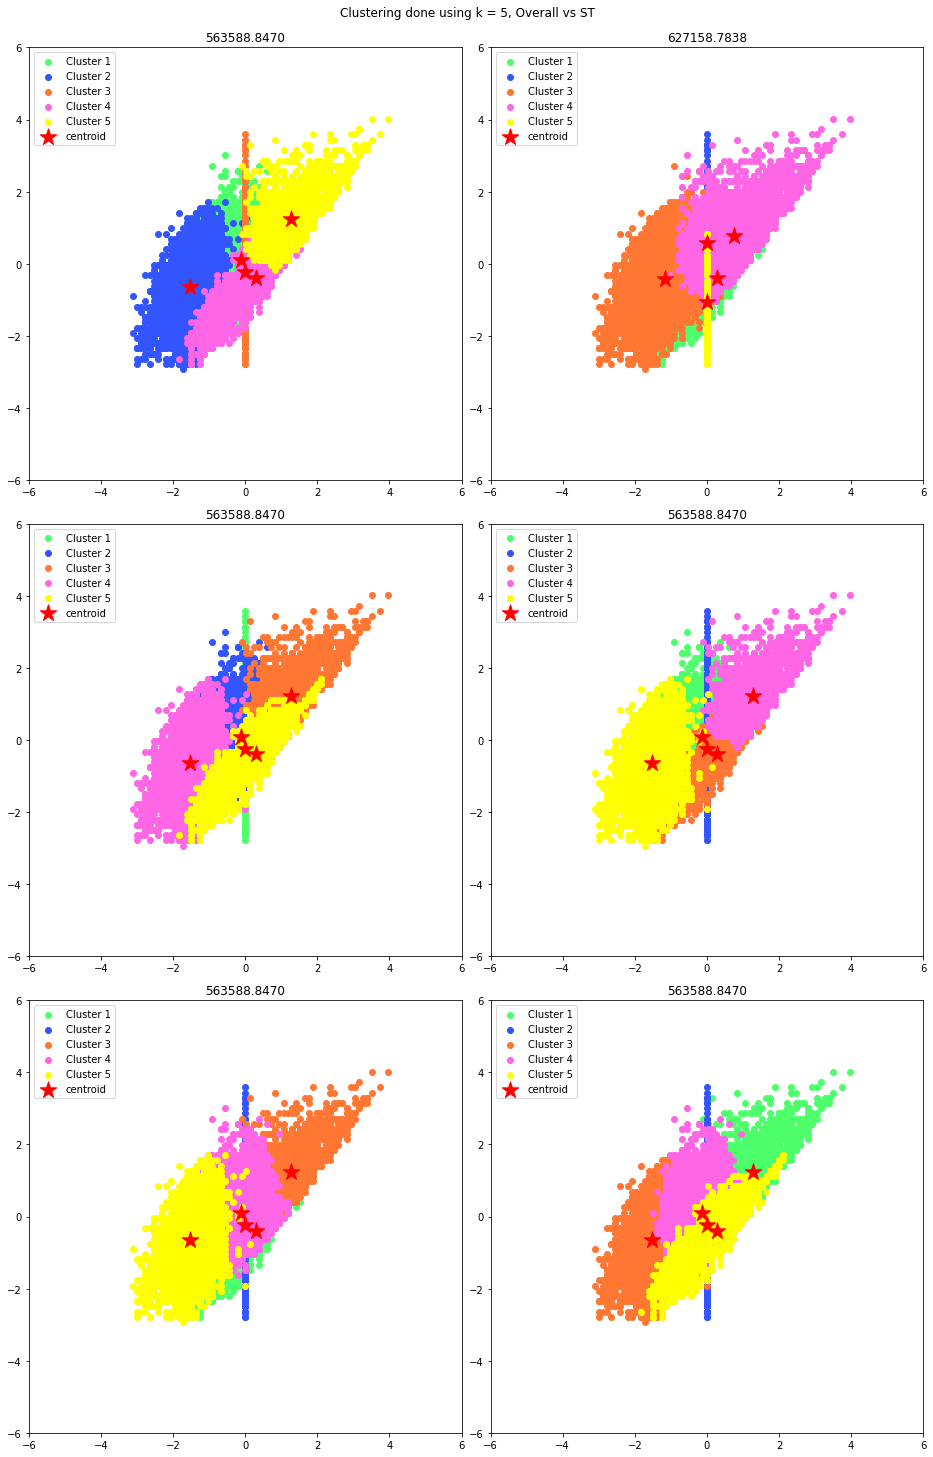

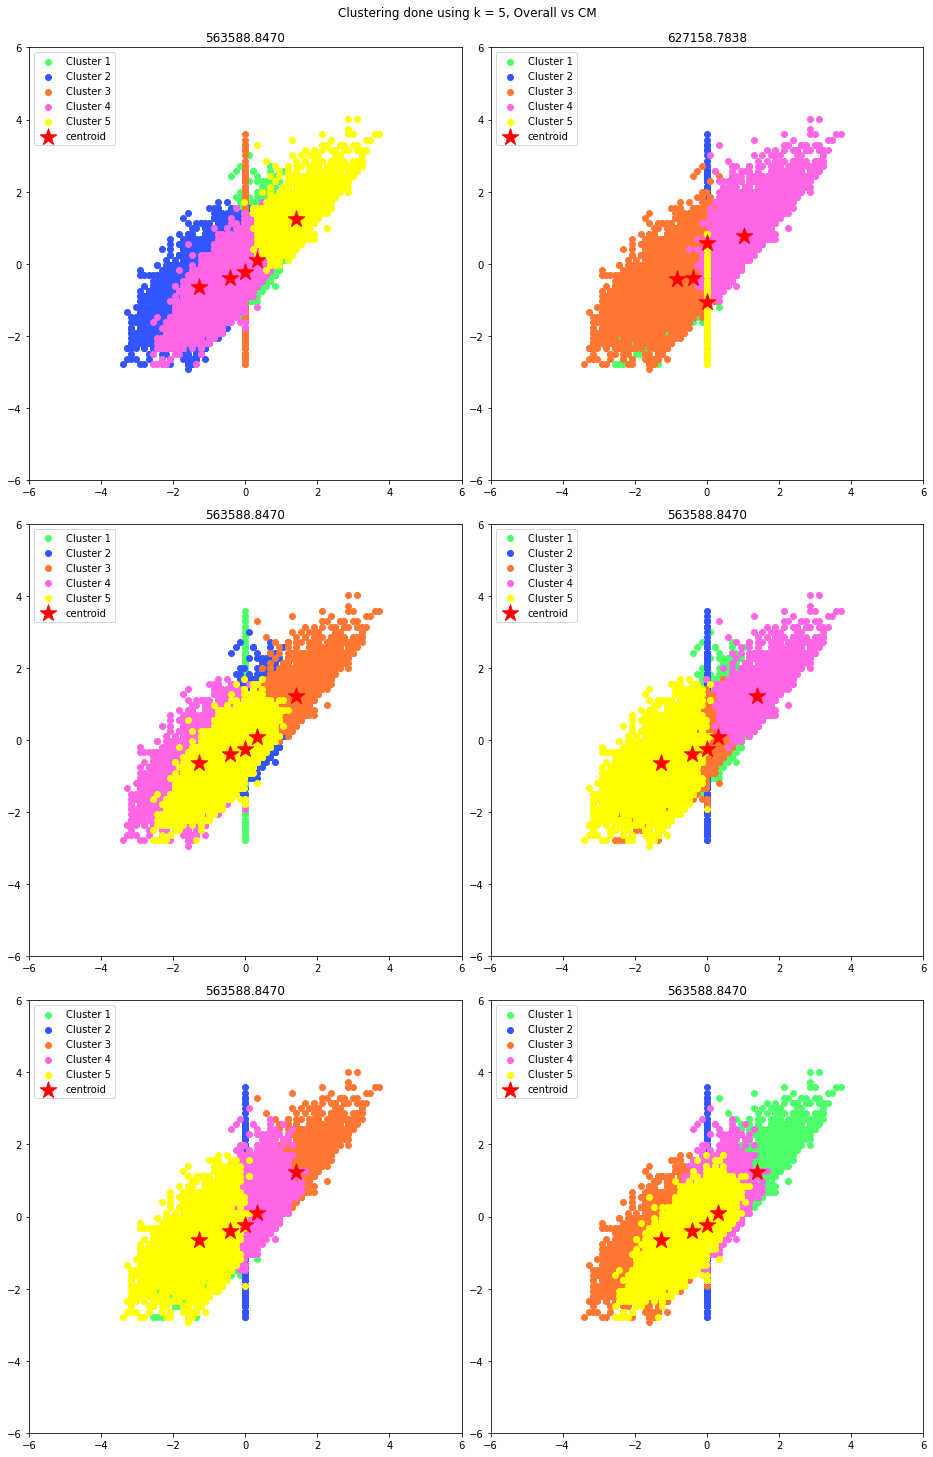

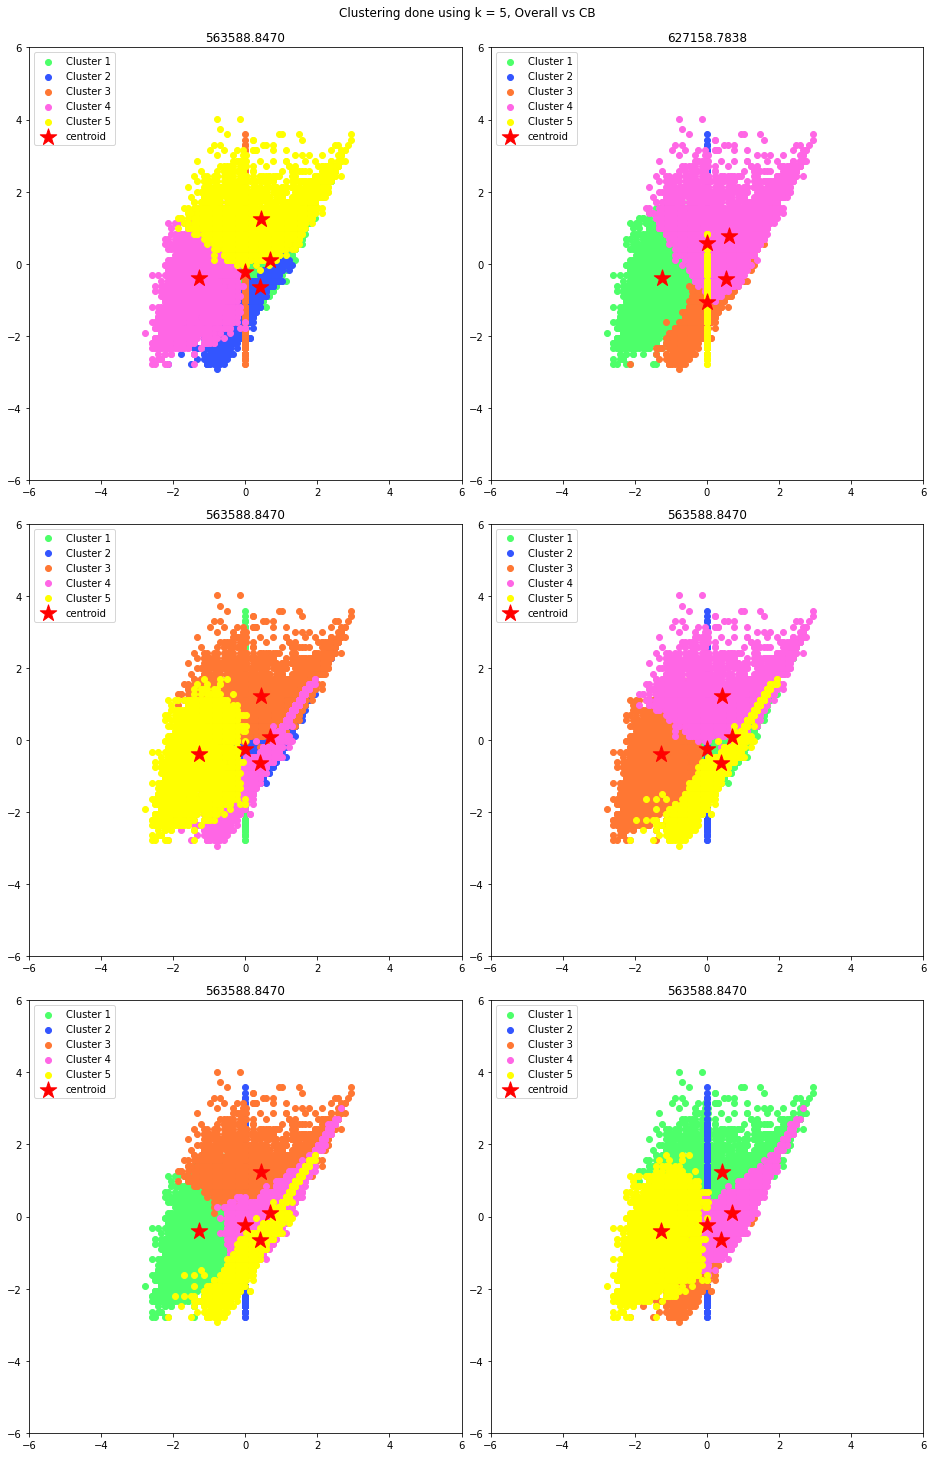

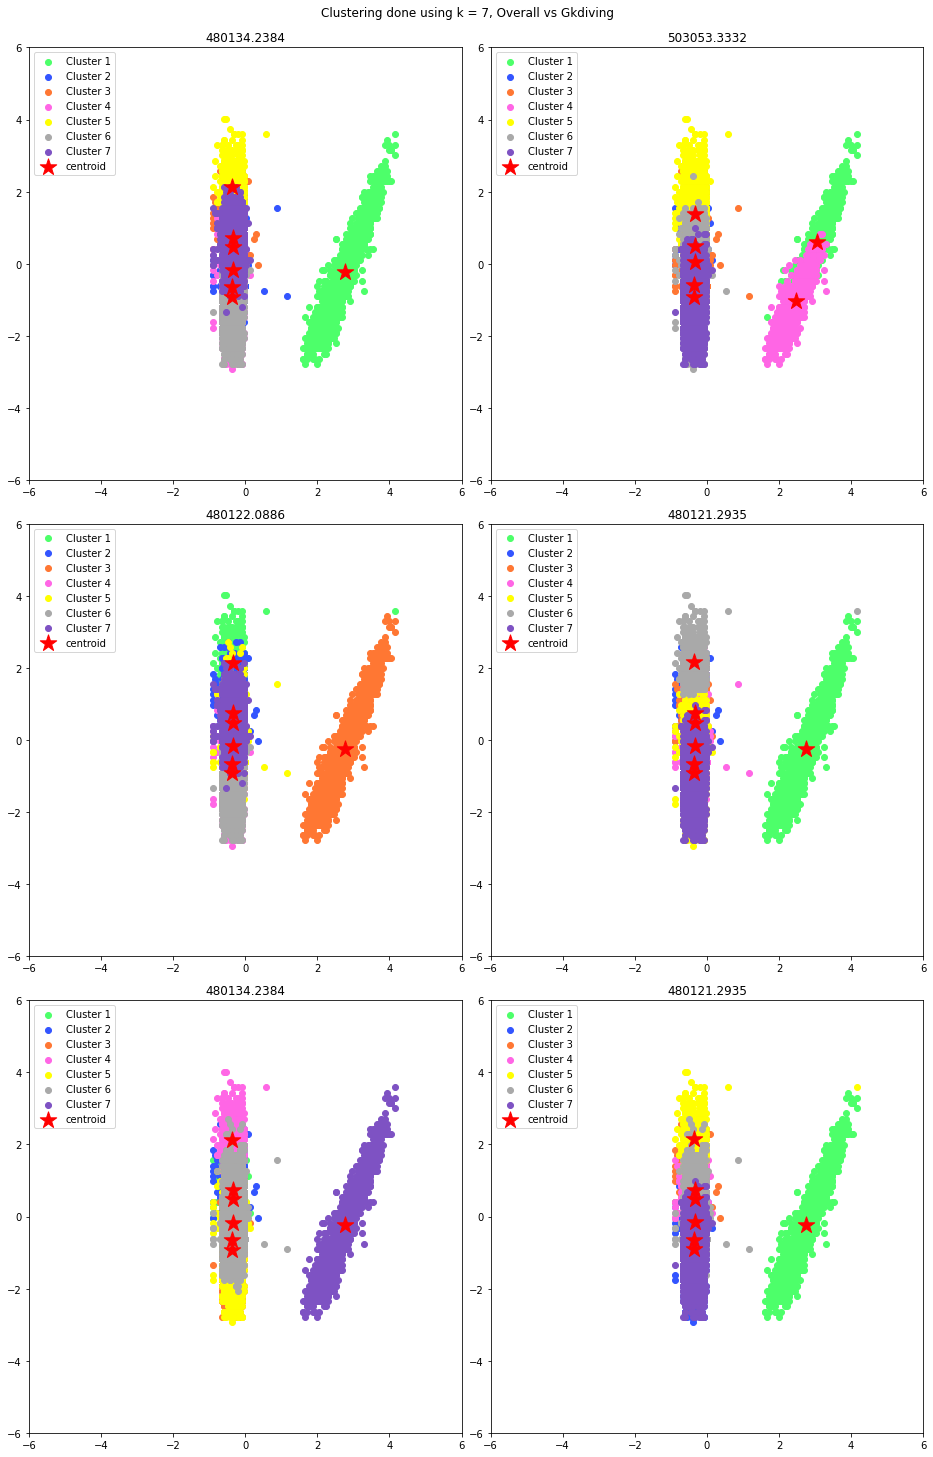

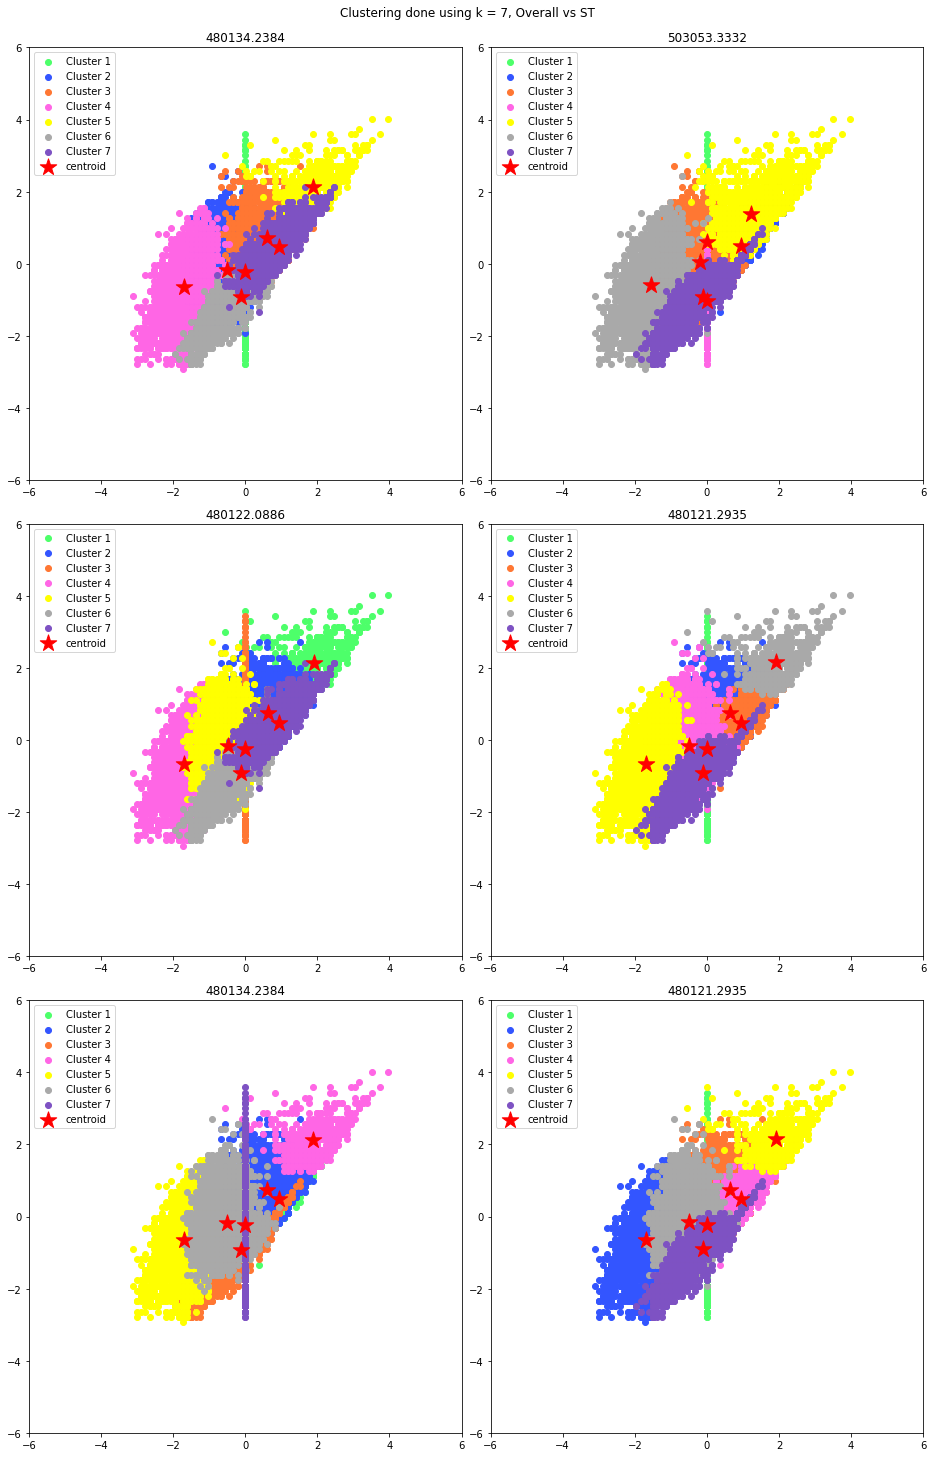

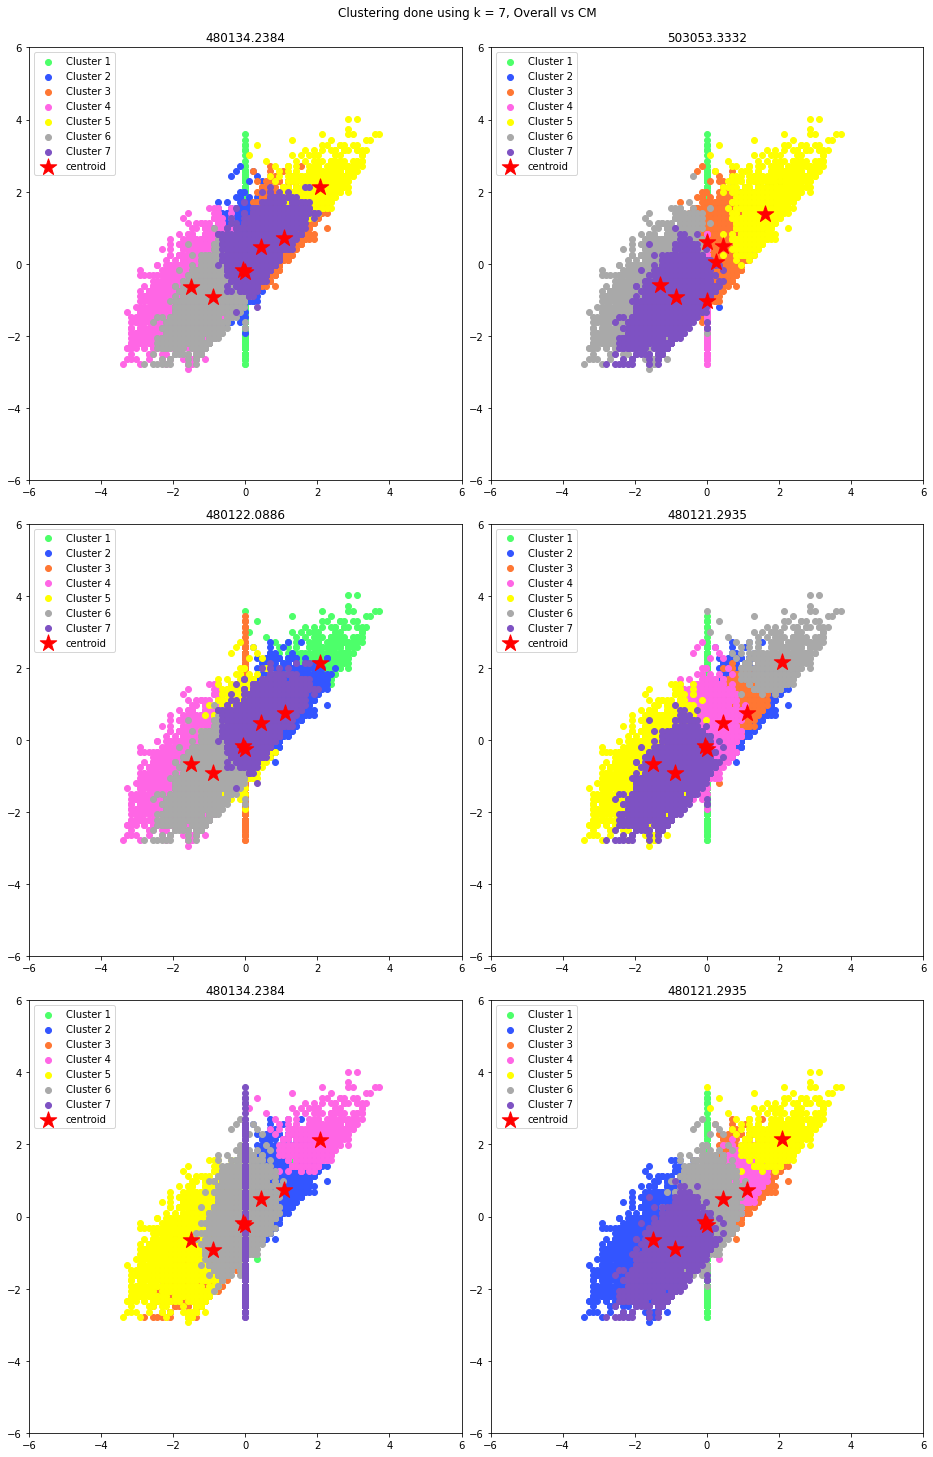

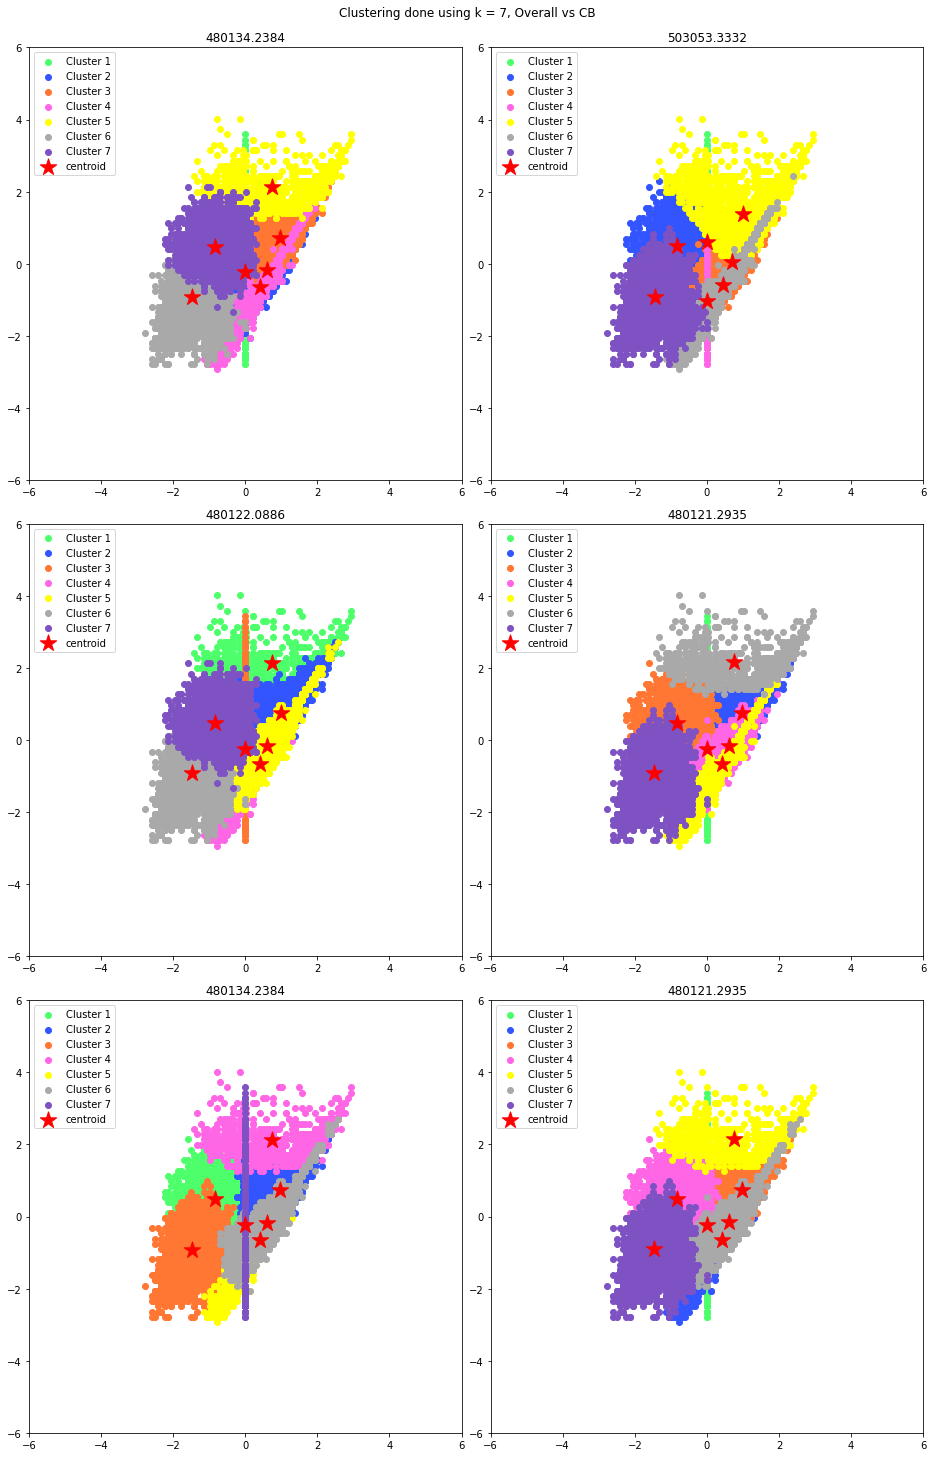

In [10]:
given_k = [3,5,7]

for j in given_k: 
    
    plot_figure1, fig_ov_gk = matplotlib.pyplot.subplots(3, 2, figsize=(13, 20))
    plot_figure2, fig_ov_st = matplotlib.pyplot.subplots(3, 2, figsize=(13, 20))
    plot_figure3, fig_ov_cm = matplotlib.pyplot.subplots(3, 2, figsize=(13, 20))
    plot_figure4, fig_ov_cb = matplotlib.pyplot.subplots(3, 2, figsize=(13, 20))
    fig_ov_gk = np.ravel(fig_ov_gk)
    fig_ov_st = np.ravel(fig_ov_st)
    fig_ov_cm = np.ravel(fig_ov_cm)
    fig_ov_cb = np.ravel(fig_ov_cb)
    
    for i in range(6):
        
        km = Kmeans(n_clusters=j)
        km.fit(X_std)
        centroids = km.centroids
        
        '''
        Graph : Overall vs Gkdiving 
        '''
        fig_ov_gk[i].scatter(X_std[km.labels == 0, 69], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        fig_ov_gk[i].scatter(X_std[km.labels == 1, 69], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        fig_ov_gk[i].scatter(X_std[km.labels == 2, 69], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            fig_ov_gk[i].scatter(X_std[km.labels == 3, 69], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            fig_ov_gk[i].scatter(X_std[km.labels == 4, 69], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        if j > 5:
            fig_ov_gk[i].scatter(X_std[km.labels == 5, 69], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            fig_ov_gk[i].scatter(X_std[km.labels == 6, 69], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])

        fig_ov_gk[i].scatter(centroids[:, 69], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        fig_ov_gk[i].set_xlim([-6, 6])
        fig_ov_gk[i].set_ylim([-6, 6])
        fig_ov_gk[i].legend(loc='upper left')
        fig_ov_gk[i].set_title(f'{km.error:.4f}')
        fig_ov_gk[i].set_aspect('equal')
        
        ''' 
        Graph : Overall vs ST 
        '''
        fig_ov_st[i].scatter(X_std[km.labels == 0, 15], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        fig_ov_st[i].scatter(X_std[km.labels == 1, 15], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        fig_ov_st[i].scatter(X_std[km.labels == 2, 15], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            fig_ov_st[i].scatter(X_std[km.labels == 3, 15], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            fig_ov_st[i].scatter(X_std[km.labels == 4, 15], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        if j > 5:
            fig_ov_st[i].scatter(X_std[km.labels == 5, 15], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            fig_ov_st[i].scatter(X_std[km.labels == 6, 15], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])
        fig_ov_st[i].scatter(centroids[:, 15], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        fig_ov_st[i].set_xlim([-6, 6])
        fig_ov_st[i].set_ylim([-6, 6])
        fig_ov_st[i].legend(loc='upper left')
        fig_ov_st[i].set_title(f'{km.error:.4f}')
        fig_ov_st[i].set_aspect('equal')
        
        ''' 
        Graph : Overall vs CM  
        '''
        fig_ov_cm[i].scatter(X_std[km.labels == 0, 27], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        fig_ov_cm[i].scatter(X_std[km.labels == 1, 27], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        fig_ov_cm[i].scatter(X_std[km.labels == 2, 27], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            fig_ov_cm[i].scatter(X_std[km.labels == 3, 27], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            fig_ov_cm[i].scatter(X_std[km.labels == 4, 27], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        if j > 5:
            fig_ov_cm[i].scatter(X_std[km.labels == 5, 27], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            fig_ov_cm[i].scatter(X_std[km.labels == 6, 27], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])
        fig_ov_cm[i].scatter(centroids[:, 27], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        fig_ov_cm[i].set_xlim([-6, 6])
        fig_ov_cm[i].set_ylim([-6, 6])
        fig_ov_cm[i].legend(loc='upper left')
        fig_ov_cm[i].set_title(f'{km.error:.4f}')
        fig_ov_cm[i].set_aspect('equal')
        
        ''' 
        Graph : Overall vs CB  
        '''
        fig_ov_cb[i].scatter(X_std[km.labels == 0, 37], X_std[km.labels == 0, 1], c=clist[0], label=llist[0])
        fig_ov_cb[i].scatter(X_std[km.labels == 1, 37], X_std[km.labels == 1, 1], c=clist[1], label=llist[1])
        fig_ov_cb[i].scatter(X_std[km.labels == 2, 37], X_std[km.labels == 2, 1], c=clist[2], label=llist[2])
        if j > 3:
            fig_ov_cb[i].scatter(X_std[km.labels == 3, 37], X_std[km.labels == 3, 1], c=clist[3], label=llist[3])
            fig_ov_cb[i].scatter(X_std[km.labels == 4, 37], X_std[km.labels == 4, 1], c=clist[4], label=llist[4])
        if j > 5:
            fig_ov_cb[i].scatter(X_std[km.labels == 5, 37], X_std[km.labels == 5, 1], c=clist[5], label=llist[5])
            fig_ov_cb[i].scatter(X_std[km.labels == 6, 37], X_std[km.labels == 6, 1], c=clist[6], label=llist[6])
        fig_ov_cb[i].scatter(centroids[:, 37], centroids[:, 1], c='red', marker='*', s=300, label='centroid')
        fig_ov_cb[i].set_xlim([-6, 6])
        fig_ov_cb[i].set_ylim([-6, 6])
        fig_ov_cb[i].legend(loc='upper left')
        fig_ov_cb[i].set_title(f'{km.error:.4f}')
        fig_ov_cb[i].set_aspect('equal')
        
    plot_figure1.tight_layout()
    plot_figure1.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs Gkdiving', y=1.01)
    plot_figure2.tight_layout()
    plot_figure2.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs ST', y=1.01 )
    plot_figure3.tight_layout()
    plot_figure3.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs CM', y=1.01 )
    plot_figure4.tight_layout()
    plot_figure4.suptitle(f'Clustering done using k = ' + str(j)+', Overall vs CB', y=1.01)

In the above graphs, we choose different initial centroids everytime we run the algorithm. As we are running K-means 6 times for each K, we see 6 graphs for each case. The sum of squared errors will be same, whether we plot the Overall vs St, Overall vs CM, etc. as these attributes are being used only for visualization and all the attributes have been used while forming the clusters. For all the graphs, the sum of squared errors have been printed on the top, and for each K, we will consider the case with least sum of squared distances.

## Elbow Method

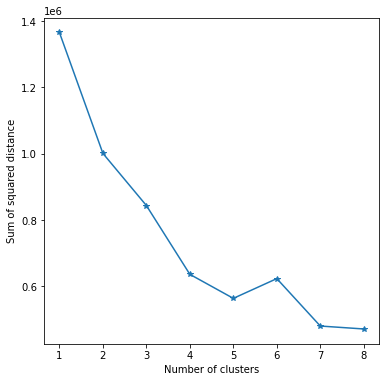

In [13]:
squarederr = []

for i in range(1, 9):
    km = Kmeans(n_clusters=i)
    km.fit(X_std)
    squarederr.append(km.error)
matplotlib.pyplot.figure(figsize=(6, 6))
matplotlib.pyplot.plot(list(range(1, 9)), squarederr, '-*')
matplotlib.pyplot.xlabel('Number of clusters')
matplotlib.pyplot.ylabel('Sum of squared distance');

From the above graph we can see that the **best K is 4** because an elbow can be seen to be formed.  
The algorithm will give different graphs in different runs but K=4 consistently has an elbow in numerous plots. 
  
However, elbow method is not the best method to select select number of clusters as the error function is mostly monotonically decreasing for all Ks.

## Silhoutte Analysis

Running for 2 clusters.
Running for 3 clusters.
Running for 4 clusters.
Running for 5 clusters.
Running for 6 clusters.
Running for 7 clusters.

The silhouette scores obtained are:
+--------------------+--------------------------+
| Number of clusters | Average Silhouette Score |
+--------------------+--------------------------+
|         2          |       0.241160759        |
|         3          |       0.212463752        |
|         4          |       0.273972972        |
|         5          |       0.247761186        |
|         6          |        0.24155582        |
|         7          |       0.231805248        |
+--------------------+--------------------------+


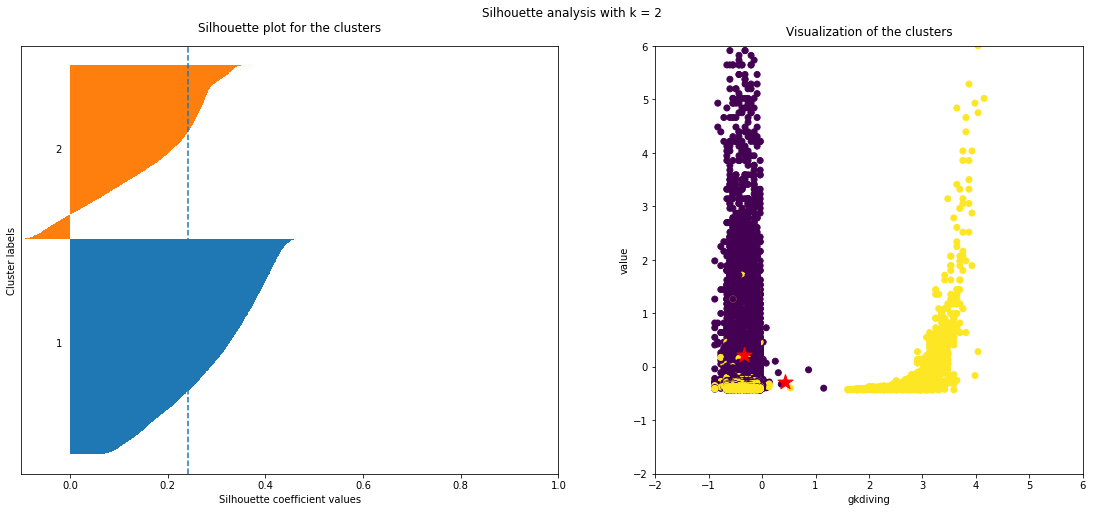

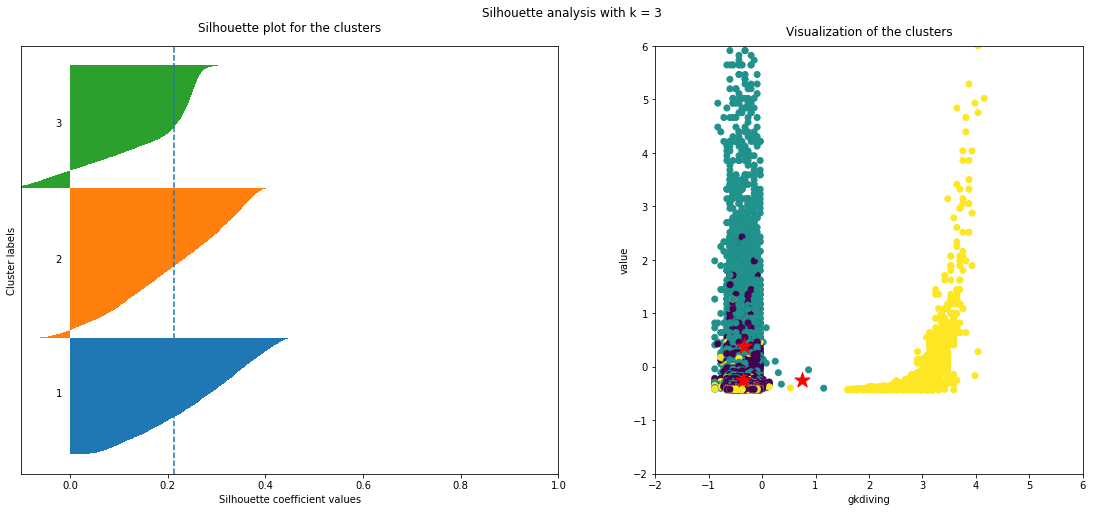

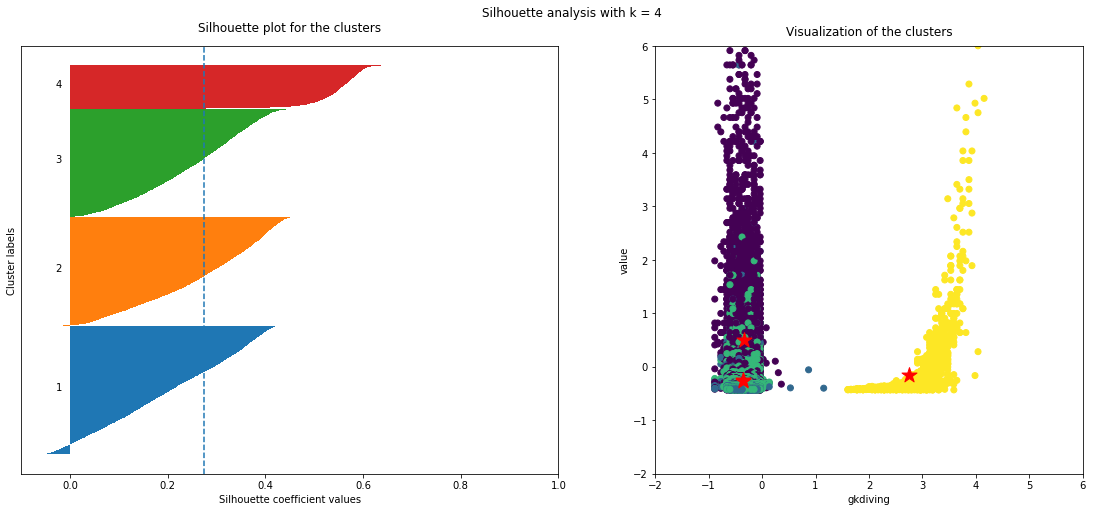

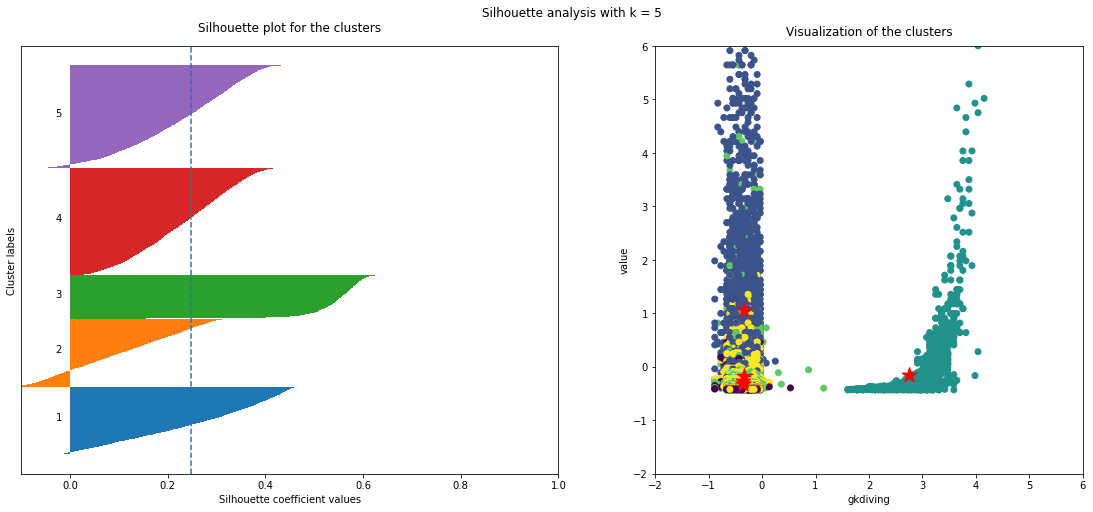

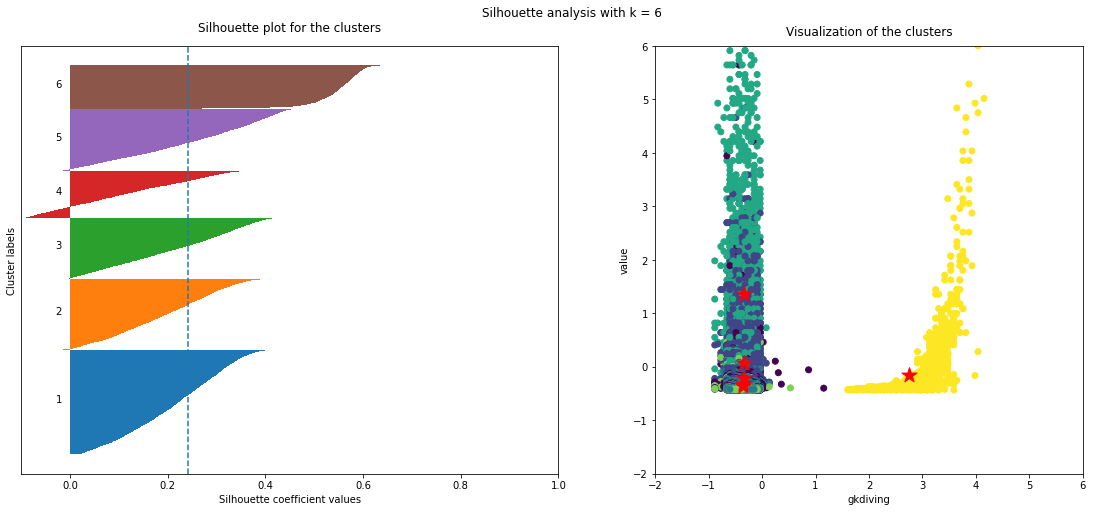

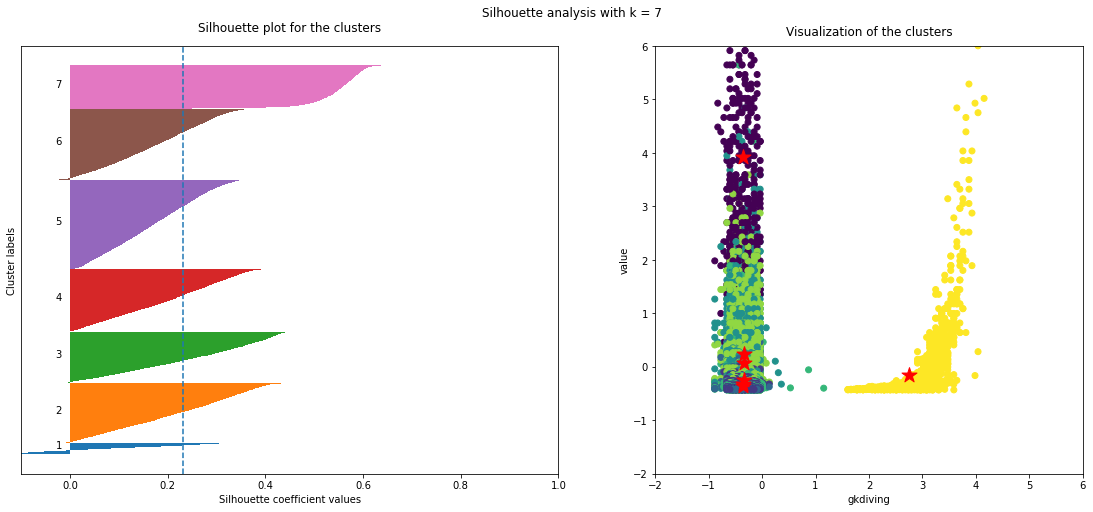

In [27]:
from prettytable import PrettyTable
t_tab = PrettyTable(['Number of clusters', 'Average Silhouette Score'])

kvals= [2,3,4,5,6,7]
for k in kvals:
    plot_figure,(left_fig, right_fig) = matplotlib.pyplot.subplots(1, 2)
    plot_figure.set_size_inches(16, 7)
    
    '''
    Run the Kmeans algorithm
    '''
    km = Kmeans(n_clusters=k)
    km.fit(X_std)
    labels = km.predict(X_std)
    centroids = km.centroids
    
    ''' 
    Get silhouette samples 
    '''
    silhouette_vals = silhouette_samples(X_std, labels)

    ''' 
    Silhouette plot
    '''
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper =  y_upper + len(cluster_silhouette_vals)
        left_fig.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        left_fig.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower =  y_lower + len(cluster_silhouette_vals)

    '''
    The silhouette_score gives the average value for all the samples.
    This gives a perspective into the density and separation of the formed clusters.
    '''
    avg_score = np.mean(silhouette_vals)
    print("Running for " + str(k) + " clusters.")
    t_tab.add_row([k, avg_score.round(9)])
    
    left_fig.axvline(avg_score, linestyle='--')
    left_fig.set_yticks([])
    left_fig.set_xlim([-0.1, 1])
    left_fig.set_xlabel('Silhouette coefficient values')
    left_fig.set_ylabel('Cluster labels')
    left_fig.set_title('Silhouette plot for the clusters', y=1.02);
    
    '''
    Scatter plot of data colored with labels
    '''
    right_fig.scatter(X_std[:, 69], X_std[:, 3], c=labels)
    right_fig.scatter(centroids[:, 69], centroids[:, 3], marker='*', c='r', s=250)
    right_fig.set_xlim([-2, 6])
    right_fig.set_ylim([-2, 6])
    right_fig.set_xlabel('gkdiving')
    right_fig.set_ylabel('value')
    right_fig.set_title('Visualization of the clusters', y=1.01)
    right_fig.set_aspect('equal')
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.suptitle('Silhouette analysis with k = ' + str(k), y=1.01)

print("\nThe silhouette scores obtained are:")
print(t_tab)

From the above runs, it can be seen that the silhouette average score for 4 is the best so **k = 4 is the optimal number of clusters**. Between 3 and 5 **sometimes 3 performs better and sometimes 5 performs better**. The reason for this might be some inherent bias in the data due to which the random initial centroids give different results.  

**Important points**
* Kmeans **assumes spherical shapes of clusters** and doesn’t work well when clusters are in different shapes such as ellipsoids.
* In case of **overlapping** between clusters, kmeans doesn’t have any intrinsic measure to determine for which cluster to assign to the data point.